라이브러리

In [48]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
tank = 1
model_name = 'reredoRegressor_tank1nomal'

In [49]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

데이터셋 설정

In [50]:
#자포니카 훈련 데이터
japonica_training_food_supply_tb = pd.read_csv("eeldata/data/Training/Origin/Management/Japonica/food_supply_tb.csv")
japonica_training_sensor_val_tb = pd.read_csv("eeldata/data/Training/Origin/Sensor/Japonica/sensor_val_tb.csv")

#자포니카 검증 데이터
japonica_validation_food_supply_tb = pd.read_csv("eeldata/data/Validation/Origin/Management/Japonica/food_supply_tb.csv")
japonica_validation_sensor_val_tb = pd.read_csv("eeldata/data/Validation/Origin/Sensor/Japonica/sensor_val_tb.csv")


In [51]:
# 자포니카 사료 공급 데이터 정제
# null제거
japonica_training_food_supply_tb = japonica_training_food_supply_tb[japonica_training_food_supply_tb['feed_quantity'].notnull()]
japonica_validation_food_supply_tb = japonica_validation_food_supply_tb[japonica_validation_food_supply_tb['feed_quantity'].notnull()]

# 시계열 데이터 변환
japonica_training_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_training_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].apply(str)
japonica_training_food_supply_tb["feed_dt"] = japonica_training_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)
japonica_validation_food_supply_tb['feed_dt'] = pd.to_datetime(japonica_validation_food_supply_tb['feed_dt'], format='%Y%m%d%H%M', errors='raise')
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].apply(str)
japonica_validation_food_supply_tb["feed_dt"] = japonica_validation_food_supply_tb["feed_dt"].str.slice(start=0, stop=16)

In [52]:
# 자포니카 센서 데이터 정제

# 한 개 탱크
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[japonica_training_sensor_val_tb['tank_id']==tank]
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[japonica_validation_sensor_val_tb['tank_id']==tank]

#시계열 변환
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].apply(str)
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_training_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_training_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].apply(str)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb['mea_dt'] = pd.to_datetime(japonica_validation_sensor_val_tb['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 시계열 데이터의 개수 확인
training_counts = japonica_training_sensor_val_tb.groupby(japonica_training_sensor_val_tb['mea_dt'].dt.date).size()
validation_counts = japonica_validation_sensor_val_tb.groupby(japonica_validation_sensor_val_tb['mea_dt'].dt.date).size()

# 개수가 1440이 아닌 시계열 삭제
to_delete = training_counts[training_counts != 1440].index
japonica_training_sensor_val_tb = japonica_training_sensor_val_tb[~japonica_training_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]
to_delete = validation_counts[validation_counts != 1440].index
japonica_validation_sensor_val_tb = japonica_validation_sensor_val_tb[~japonica_validation_sensor_val_tb['mea_dt'].dt.date.isin(to_delete)]

#시계열 데이터 문자 타입으로 변경
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_training_sensor_val_tb["mea_dt"] = japonica_training_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].dt.strftime('%Y-%m-%d %H:%M')
japonica_validation_sensor_val_tb["mea_dt"] = japonica_validation_sensor_val_tb["mea_dt"].str.slice(start=0, stop=16)


In [53]:
# 자포니카 훈련 데이터 및 시계열 데이터 병합
japonica_training = pd.merge(left = japonica_training_sensor_val_tb, right = japonica_training_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])
japonica_validation = pd.merge(left = japonica_validation_sensor_val_tb, right = japonica_validation_food_supply_tb, how = "left", left_on = ["farm_id","tank_id", "mea_dt"], right_on = ["farm_id","tank_id", "feed_dt"])

japonica_training['mea_dt'] = pd.to_datetime(japonica_training['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')
japonica_validation['mea_dt'] = pd.to_datetime(japonica_validation['mea_dt'], format='%Y-%m-%d %H:%M', errors='raise')

# 사용할 features 선택
feature_origin = ['tank_id','mea_dt', 'do_mg','do_temp', 'ph', 'orp', 'co2_mg', 'air_oxy', 'light_ma', 'feed_quantity', 'water_quantity']
japonica_training_features = japonica_training[feature_origin]
japonica_validation_features = japonica_validation[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.fillna(0)
japonica_validation_features = japonica_validation_features.fillna(0)

# 날짜 데이터를 인덱스로 전환
japonica_training_features.set_index('mea_dt', inplace=True)
japonica_validation_features.set_index('mea_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_data = japonica_training_features.sort_index()
japonica_validation_data = japonica_validation_features.sort_index()

# 8월 1달간 데이터만 추출
japonica_training_data = japonica_training_data.loc['2021-07-21 00:00':'2021-09-10 23:59']
japonica_validation_data = japonica_validation_data.loc['2021-07-21 00:00':'2021-09-10 23:59']

In [54]:
japonica_training_features_X = japonica_training_data[['do_mg','feed_quantity']]

japonica_validation_features_X = japonica_validation_data[['do_mg', 'feed_quantity']]

In [55]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max 스케일러 객체를 생성합니다.
scaler = MinMaxScaler()

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(japonica_training_features_X)
japonica_training_features_X = pd.DataFrame(normalized_data, columns=japonica_training_features_X.columns)

normalized_data = scaler.fit_transform(japonica_validation_features_X)
japonica_validation_features_X = pd.DataFrame(normalized_data, columns=japonica_validation_features_X.columns)

In [56]:
japonica_training_features_y = japonica_training_features_X[['do_mg']]

japonica_validation_features_y = japonica_validation_features_X[['do_mg']]

In [57]:
japonica_training_features_X_chunks = []
japonica_training_features_y_chunks = []

for i in range(0, len(japonica_training_features_X) - 179):
    japonica_training_features_X_chunks.append(np.array(japonica_training_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_X_chunks = np.array(japonica_training_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_training_features_y) - 179):
    japonica_training_features_y_chunks.append(np.array(japonica_training_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_training_features_y_chunks = np.array(japonica_training_features_y_chunks, dtype=np.float64)


In [58]:
japonica_validation_features_X_chunks = []
japonica_validation_features_y_chunks = []


for i in range(0, len(japonica_validation_features_X) - 179):
    japonica_validation_features_X_chunks.append(np.array(japonica_validation_features_X.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_X_chunks = np.array(japonica_validation_features_X_chunks, dtype=np.float64)

for i in range(0, len(japonica_validation_features_y) - 179):
    japonica_validation_features_y_chunks.append(np.array(japonica_validation_features_y.iloc[i:i+180].values, dtype=np.float64))
japonica_validation_features_y_chunks = np.array(japonica_validation_features_y_chunks, dtype=np.float64)

In [59]:
# shape확인
nCar = japonica_training_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64621 nVar: 2
nCar: 64621 nVar: 180
nCar: 64621 nVar: 2
nCar: 64621 nVar: 180


In [60]:
japonica_training_features_X_chunks_crop = japonica_training_features_X_chunks[:-180]
japonica_training_features_y_chunks_crop = japonica_training_features_y_chunks[180:]

japonica_validation_features_X_chunks_crop = japonica_validation_features_X_chunks[:-180]
japonica_validation_features_y_chunks_crop = japonica_validation_features_y_chunks[180:]

In [61]:
nCar = japonica_training_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_training_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_X_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_chunks_crop.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y_chunks_crop.shape[0] # 데이터 개수
nVar = japonica_validation_features_y_chunks_crop.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64441 nVar: 2
nCar: 64441 nVar: 180
nCar: 64441 nVar: 2
nCar: 64441 nVar: 180


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [22]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(180, 2), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(180, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])


checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.


hist = model.fit(japonica_training_features_X_chunks_crop, japonica_training_features_y_chunks_crop, epochs = 200, batch_size = 32, validation_data=(japonica_validation_features_X_chunks_crop, japonica_validation_features_y_chunks_crop), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 180, 128)          67072     
_________________________________________________________________
lstm_4 (LSTM)                (None, 180, 64)           49408     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 180)               5940      
Total params: 134,836
Trainable params: 134,836
Non-trainable params: 0
_________________________________________________________________


2023-07-08 19:47:55.940964: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2023-07-08 19:48:00.294069: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200
2023-07-08 19:48:01.381404: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2014/2014 [==============================] - 105s 50ms/step - loss: 0.0095 - mae: 0.0576 - r_squared: 0.5644 - val_loss: 0.0065 - val_mae: 0.0545 - val_r_squared: -3.4754
Epoch 2/200
2014/2014 [==============================] - 98s 49ms/step - loss: 0.0056 - mae: 0.0478 - r_squared: 0.7465 - val_loss: 0.0054 - val_mae: 0.0452 - val_r_squared: -1.5775
Epoch 3/200
2014/2014 [==============================] - 98s 49ms/step - loss: 0.0054 - mae: 0.0472 - r_squared: 0.7509 - val_loss: 0.0056 - val_mae: 0.0476 - val_r_squared: -2.1410
Epoch 4/200
2014/2014 [==============================] - 98s 49ms/step - loss: 0.0054 - mae: 0.0468 - r_squared: 0.7536 - val_loss: 0.0051 - val_mae: 0.0444 - val_r_squared: -1.6788
Epoch 5/200
2014/2014 [==============================] - 98s 49ms/step - loss: 0.0052 - mae: 0.0461 - r_squared: 0.7635 - val_loss: 0.0050 - val_mae: 0.0455 - val_r_squared: -1.9734
Epoch 6/200
2014/2014 [==============================] - 98s 49ms/step - loss: 0.0050 - mae: 0.0457 -

모델 평가

In [62]:
# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test, feed, y_test_shape):
    X_pred = model.predict(X_test_shape)
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

def grapeNEva2(model, X_test_shape, y_test, feed, y_test_shape, min_value, max_value):
    X_pred = model.predict(X_test_shape)
    X_pred = (X_pred * (max_value - min_value)) + min_value
    X_pred = np.asarray(X_pred, dtype=np.float64)
    X_pred = X_pred.reshape((-1))
    print(len(X_pred))

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='sensor do')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction do')  # x축에 년월일, y축에 시분
    plt.plot(y_test.index, feed, color='green', marker='o', linestyle='None', label='feed_quantity')  # x축에 년월일, y축에 시분
    plt.xlabel('date')
    plt.ylabel('do')
    plt.title(model_name)
    plt.legend(['sensor do','prediction do','feed_quantity'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test_shape)
    print("MSE // MAE // R-squared ", result)

In [63]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[-0.07332221 -0.12861672  0.06165072 ...  0.3677745  -0.14177826
   0.17029288]
 [-0.0055382   0.7345747  -0.24041146 ...  0.23963217  0.0732434
   0.34968078]]


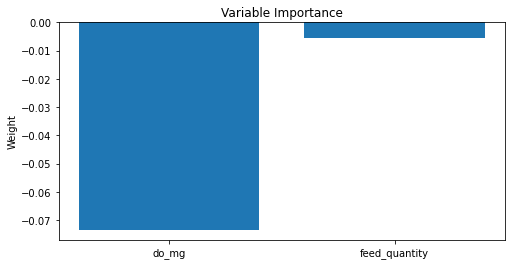

In [64]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(2), weights[:, 0])
ax.set_xticks(range(2))
ax.set_xticklabels(['do_mg', 'feed_quantity'])
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

In [65]:
japonica_validation_test = japonica_validation_data[['do_mg', 'feed_quantity']]

from sklearn.preprocessing import MinMaxScaler

# Min-Max 스케일러 객체를 생성합니다.
scaler = MinMaxScaler()


In [66]:
X_test = japonica_validation_test.loc['2021-07-21 00:00':'2021-09-08 20:59']

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(X_test)
X_test_nomal = pd.DataFrame(normalized_data, columns=X_test.columns)

X_test_reshape = np.asarray(X_test_nomal, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 359 nVar: 2


In [67]:
y_date = japonica_validation_test.loc['2021-07-21 03:00':'2021-09-08 23:59']

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(y_date)
y_test_nomal = pd.DataFrame(normalized_data, columns=y_date.columns)

y_test_nomal = y_test_nomal[['do_mg']]
y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test_nomal, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 64620 nVar: 1
nCar: 359 nVar: 180


64620


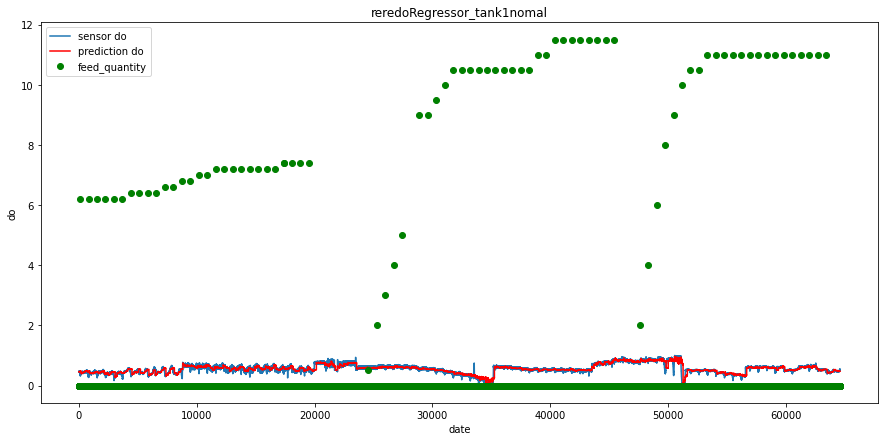

12/12 [==============================] - 1s 17ms/step - loss: 0.0055 - mae: 0.0456 - r_squared: 0.3853
MSE // MAE // R-squared  [0.005478410981595516, 0.04564080014824867, 0.3853435218334198]
64620


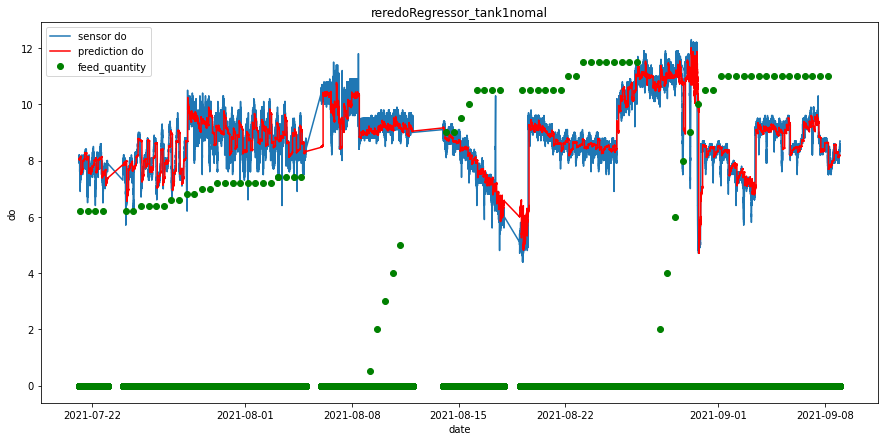

12/12 [==============================] - 0s 17ms/step - loss: 0.0055 - mae: 0.0456 - r_squared: 0.3853
MSE // MAE // R-squared  [0.005478410981595516, 0.04564080014824867, 0.3853435218334198]


In [68]:
grapeNEva(model, X_test_reshape, y_test_nomal, y_date[['feed_quantity']], y_test_reshape)

min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]
grapeNEva2(model, X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape, min_value, max_value)

In [69]:
X_test = japonica_validation_test.loc['2021-07-21 00:00':'2021-07-31 20:59']

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(X_test)
X_test_nomal = pd.DataFrame(normalized_data, columns=X_test.columns)

X_test_reshape = np.asarray(X_test_nomal, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 79 nVar: 2


In [70]:
y_date = japonica_validation_test.loc['2021-07-21 03:00':'2021-07-31 23:59']

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(y_date)
y_test_nomal = pd.DataFrame(normalized_data, columns=y_date.columns)

y_test_nomal = y_test_nomal[['do_mg']]
y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test_nomal, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 14220 nVar: 1
nCar: 79 nVar: 180


14220


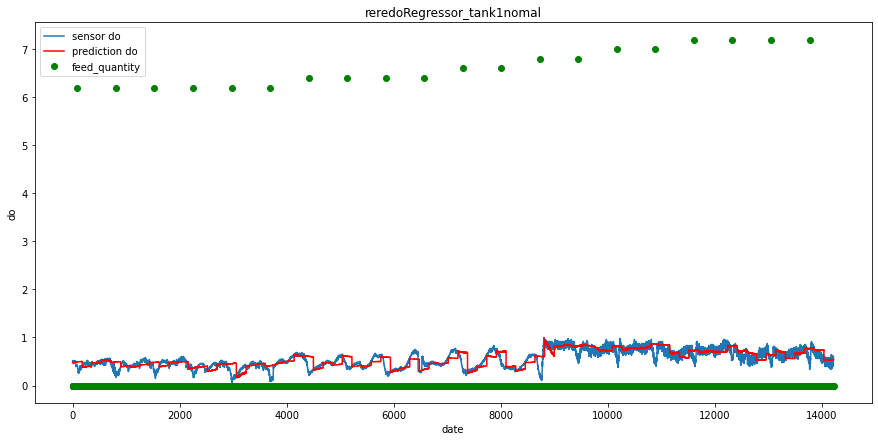

3/3 [==============================] - 0s 17ms/step - loss: 0.0157 - mae: 0.0914 - r_squared: 0.0926
MSE // MAE // R-squared  [0.015684232115745544, 0.09138339012861252, 0.09256017208099365]
14220


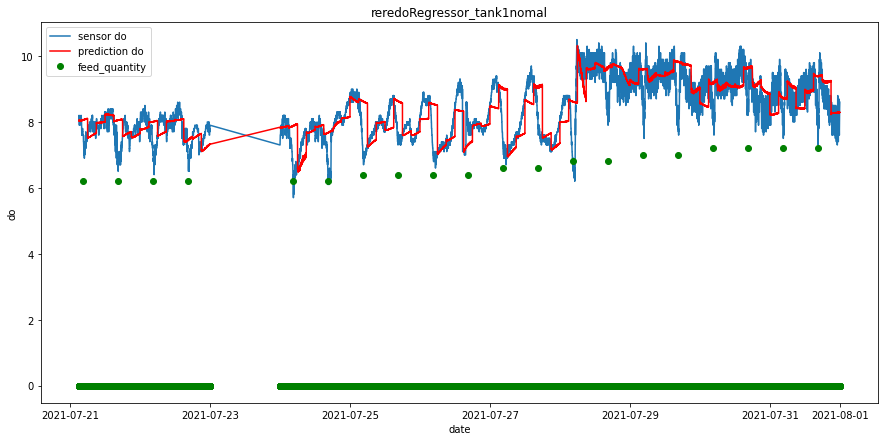

3/3 [==============================] - 0s 17ms/step - loss: 0.0157 - mae: 0.0914 - r_squared: 0.0926
MSE // MAE // R-squared  [0.015684232115745544, 0.09138339012861252, 0.09256017208099365]


In [71]:
grapeNEva(model, X_test_reshape, y_test_nomal, y_date[['feed_quantity']], y_test_reshape)

min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]
grapeNEva2(model, X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape, min_value, max_value)

In [72]:
X_test = japonica_validation_test.loc['2021-07-21 00:00':'2021-07-21 20:59']

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(X_test)
X_test_nomal = pd.DataFrame(normalized_data, columns=X_test.columns)

X_test_reshape = np.asarray(X_test_nomal, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 7 nVar: 2


In [73]:
y_date = japonica_validation_test.loc['2021-07-21 03:00':'2021-07-21 23:59']

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(y_date)
y_test_nomal = pd.DataFrame(normalized_data, columns=y_date.columns)

y_test_nomal = y_test_nomal[['do_mg']]
y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test_nomal, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 1260 nVar: 1
nCar: 7 nVar: 180


1260


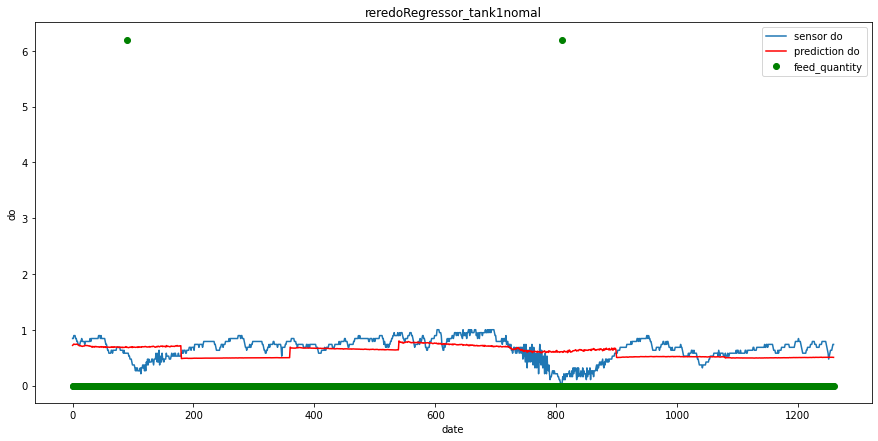

1/1 [==============================] - 0s 48ms/step - loss: 0.0457 - mae: 0.1818 - r_squared: -0.2342
MSE // MAE // R-squared  [0.045654308050870895, 0.18184199929237366, -0.23420631885528564]
1260


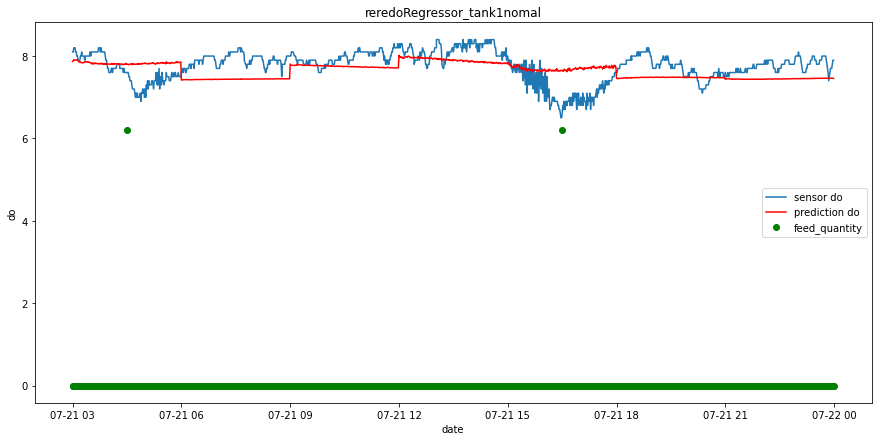

1/1 [==============================] - 0s 66ms/step - loss: 0.0457 - mae: 0.1818 - r_squared: -0.2342
MSE // MAE // R-squared  [0.045654308050870895, 0.18184199929237366, -0.23420631885528564]


In [74]:
grapeNEva(model, X_test_reshape, y_test_nomal, y_date[['feed_quantity']], y_test_reshape)

min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]
grapeNEva2(model, X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape, min_value, max_value)

In [75]:
X_test = japonica_validation_test.loc['2021-07-21 00:00':'2021-07-21 11:59']

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(X_test)
X_test_nomal = pd.DataFrame(normalized_data, columns=X_test.columns)

X_test_reshape = np.asarray(X_test_nomal, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 2


In [76]:
y_date = japonica_validation_test.loc['2021-07-21 03:00':'2021-07-21 14:59']

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(y_date)
y_test_nomal = pd.DataFrame(normalized_data, columns=y_date.columns)

y_test_nomal = y_test_nomal[['do_mg']]
y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test_nomal, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 4 nVar: 180


720


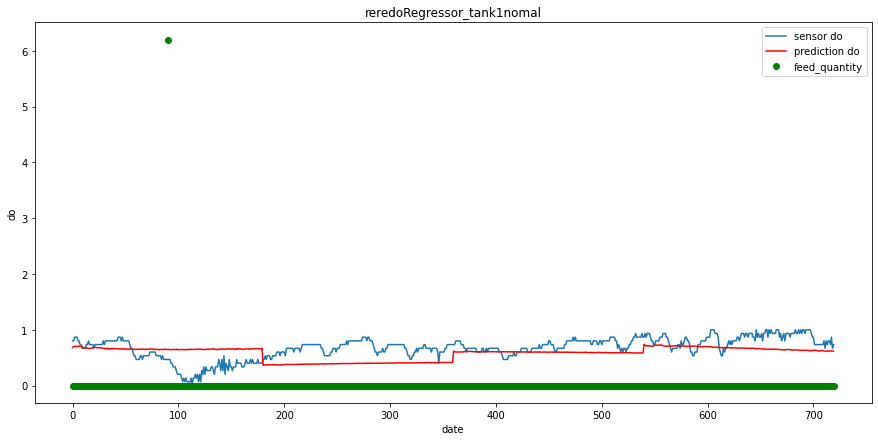

1/1 [==============================] - 0s 69ms/step - loss: 0.0571 - mae: 0.2036 - r_squared: -0.5591
MSE // MAE // R-squared  [0.05713215470314026, 0.20356234908103943, -0.5590775012969971]
720


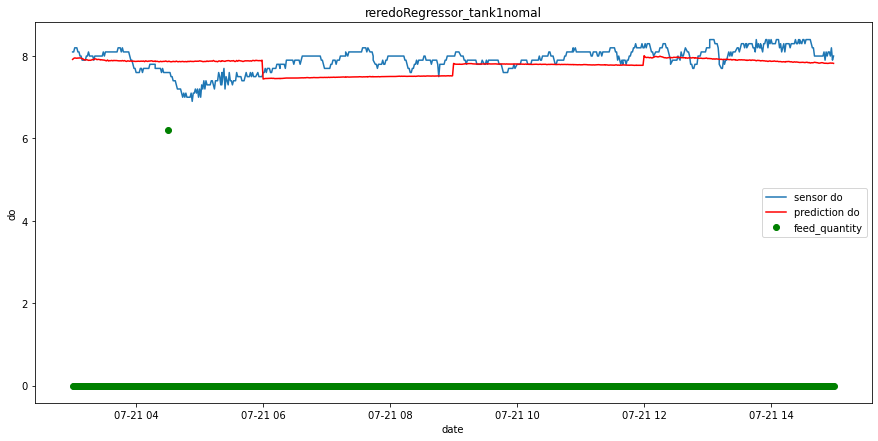

1/1 [==============================] - 0s 69ms/step - loss: 0.0571 - mae: 0.2036 - r_squared: -0.5591
MSE // MAE // R-squared  [0.05713215470314026, 0.20356234908103943, -0.5590775012969971]


In [77]:
grapeNEva(model, X_test_reshape, y_test_nomal, y_date[['feed_quantity']], y_test_reshape)

min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]
grapeNEva2(model, X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape, min_value, max_value)

In [78]:
japonica_validation_test.at['2021-07-21 08:00', 'feed_quantity'] = 6

X_test = japonica_validation_test.loc['2021-07-21 00:00':'2021-07-21 11:59']

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(X_test)
X_test_nomal = pd.DataFrame(normalized_data, columns=X_test.columns)

X_test_reshape = np.asarray(X_test_nomal, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 2


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [80]:
y_date = japonica_validation_test.loc['2021-07-21 03:00':'2021-07-21 14:59']

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(y_date)
y_test_nomal = pd.DataFrame(normalized_data, columns=y_date.columns)

y_test_nomal = y_test_nomal[['do_mg']]
y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test_nomal, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 4 nVar: 180


720


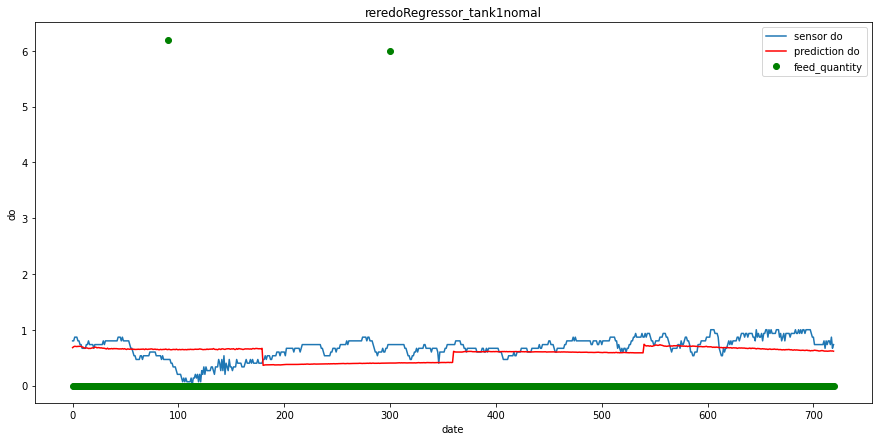

1/1 [==============================] - 0s 50ms/step - loss: 0.0570 - mae: 0.2032 - r_squared: -0.5558
MSE // MAE // R-squared  [0.05701347813010216, 0.20322012901306152, -0.5558387041091919]
720


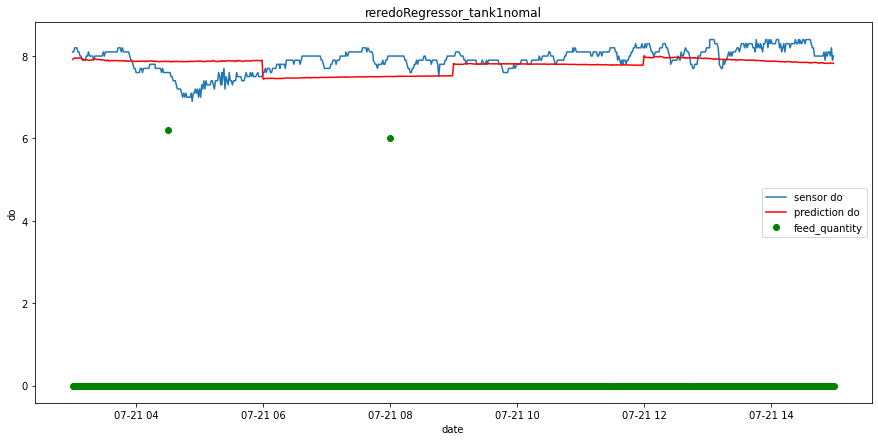

1/1 [==============================] - 0s 51ms/step - loss: 0.0570 - mae: 0.2032 - r_squared: -0.5558
MSE // MAE // R-squared  [0.05701347813010216, 0.20322012901306152, -0.5558387041091919]


In [81]:
grapeNEva(model, X_test_reshape, y_test_nomal, y_date[['feed_quantity']], y_test_reshape)

min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]
grapeNEva2(model, X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape, min_value, max_value)

In [82]:
japonica_validation_test.at['2021-07-21 04:30', 'feed_quantity'] = japonica_validation_test.at['2021-07-21 04:30', 'feed_quantity'] * 2

X_test = japonica_validation_test.loc['2021-07-21 00:00':'2021-07-21 11:59']

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(X_test)
X_test_nomal = pd.DataFrame(normalized_data, columns=X_test.columns)

X_test_reshape = np.asarray(X_test_nomal, dtype=np.float64)
X_test_reshape = X_test_reshape.reshape((-1, 180, 2))

# shape확인
nCar = X_test_reshape.shape[0] # 데이터 개수
nVar = X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 4 nVar: 2


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [83]:
y_date = japonica_validation_test.loc['2021-07-21 03:00':'2021-07-21 14:59']

# 데이터를 정규화합니다.
normalized_data = scaler.fit_transform(y_date)
y_test_nomal = pd.DataFrame(normalized_data, columns=y_date.columns)

y_test_nomal = y_test_nomal[['do_mg']]
y_test = y_date[['do_mg']]

y_test_reshape = np.asarray(y_test_nomal, dtype=np.float64)
y_test_reshape = y_test_reshape.reshape((-1, 180, 1))

nCar = y_test.shape[0] # 데이터 개수
nVar = y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = y_test_reshape.shape[0] # 데이터 개수
nVar = y_test_reshape.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 720 nVar: 1
nCar: 4 nVar: 180


720


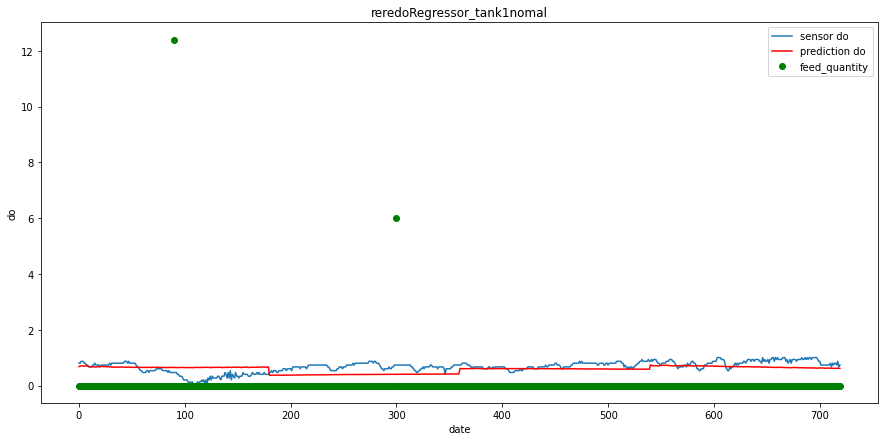

1/1 [==============================] - 0s 62ms/step - loss: 0.0571 - mae: 0.2034 - r_squared: -0.5577
MSE // MAE // R-squared  [0.057080596685409546, 0.2034084051847458, -0.5576704740524292]
720


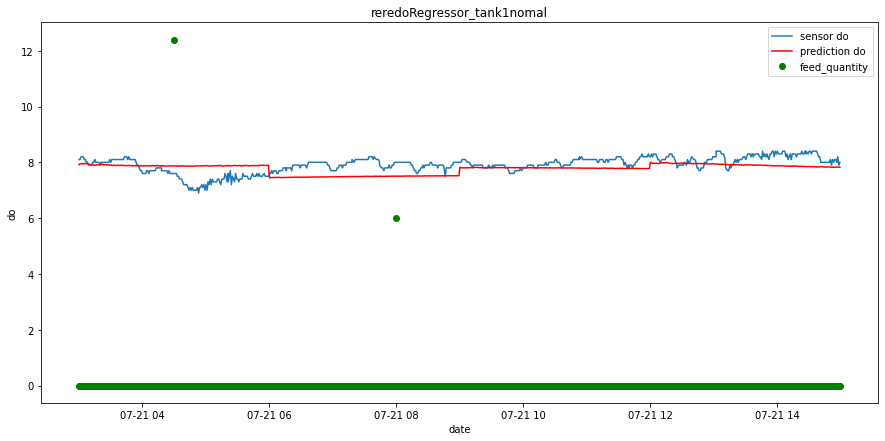

1/1 [==============================] - 0s 70ms/step - loss: 0.0571 - mae: 0.2034 - r_squared: -0.5577
MSE // MAE // R-squared  [0.057080596685409546, 0.2034084051847458, -0.5576704740524292]


In [84]:
grapeNEva(model, X_test_reshape, y_test_nomal, y_date[['feed_quantity']], y_test_reshape)

min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]
grapeNEva2(model, X_test_reshape, y_test, y_date[['feed_quantity']], y_test_reshape, min_value, max_value)